In [ ]:
import numpy as np
from skimage import io
from pathlib import Path
import re
import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_closing
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
from RedLionfishDeconv import doRLDeconvolutionFromNpArrays
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
from statistics import mode
import imageio
from PIL import Image
from PIL.TiffTags import TAGS
from tifffile import TiffFile
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
np.std([24,27,35,33,37,22,21,23,26,30,22,40,22,24,28])

5.885575587824864

In [3]:
def _ants_affine_to_distance(affine):

    dx, dy, dz = affine[9:]

    rot_x = np.arcsin(affine[6])
    cos_rot_x = np.cos(rot_x)
    rot_y = np.arctan2(affine[7] / cos_rot_x, affine[8] / cos_rot_x)
    rot_z = np.arctan2(affine[3] / cos_rot_x, affine[0] / cos_rot_x)

    deg = np.degrees

    return dx, dy, dz, deg(rot_x), deg(rot_y), deg(rot_z)

In [4]:
print('start')

start


In [5]:
mouse_ids_path = Path('matt_raw_warped')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*res*.tif'))#grab folder names/mouse ids
mouse_ids = sorted([x.as_posix() for x in mouse_ids])
data_dicts = [
    {"image":image_name}
    for image_name in mouse_ids
]

#data_dicts = [data_dicts[_i]]
re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])

'matt_raw_warped/06162021_45-XYZres288_0001_warped.tif'

# Define connected componnet removal

In [6]:
def remove_small_comps_3d(image, thresh = 500):
    """

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=1000):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

# register raw iamges

In [7]:
exclude = ['XYZres103',
           'XYZres104',
           'XYZres105',
           'XYZres105',
           'XYZres107',
           'XYZres133',
           'XYZres134',
           'XYZres135',
           'XYZres136',
           'XYZres137',
           'XYZres138',
           'XYZres139',
           'XYZres140',
           'XYZres183',
           'XYZres196',
           'XYZres197',
           'XYZres260',
           'XYZres288',
           'XYZres343',
           'XYZres340',
           'XYZres341',
           'XYZres250',
           'XYZres297',
           'XYZres295',
           'XYZres457',
           'XYZres455']

In [8]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)


In [9]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key)))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '/' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '/' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms

In [10]:
#dic

In [11]:
dic_2 = {'45/XYZres290':['45/XYZres296'],
         '45/XYZres297':['45/XYZres295'],
         '45/XYZres294':['45/XYZres298'],
         '45/XYZres288':['45/XYZres300'],
         '11/XYZres95':['11/XYZres98','11/XYZres102'],
         '11/XYZres92':[],
         '11/XYZres93':['11/XYZres93','11/XYZres96','11/XYZres97','11/XYZres100','11/XYZres101'],
         '11/XYZres91':['11/XYZres94','11/XYZres99'],
         '22/XYZres164':['22/XYZres165','22/XYZres168','22/XYZres169'],
         '22/XYZres160':['22/XYZres161'],
         '22/XYZres163':['22/XYZres166','22/XYZres167','22/XYZres170'],
         '22/XYZres159':['22/XYZres162'],
         '28/XYZres184':['28/XYZres185'],
         '28/XYZres188':['28/XYZres189','28/XYZres193','28/XYZres194'],
         '28/XYZres186':['28/XYZres187','28/XYZres188','28/XYZres190','28/XYZres191','28/XYZres192','28/XYZres195'],
         '28/XYZres183':[],
         '40/XYZres248':['40/XYZres249'],
         '40/XYZres245':['40/XYZres252'],
         '40/XYZres244':[],
         '40/XYZres243':['40/XYZres246','40/XYZres247','40/XYZres251'],
         '51/XYZres297':['51/XYZres298','51/XYZres302','51/XYZres305','51/XYZres301'],
         '51/XYZres296':['51/XYZres306'],
         '51/XYZres299':['51/XYZres300','51/XYZres303','51/XYZres304'],
         '65/XYZres397':['65/XYZres398','65/XYZres401','65/XYZres402','65/XYZres405','65/XYZres408','65/XYZres409'],
         '65/XYZres396':['65/XYZres399','65/XYZres400'],
         '65/XYZres403':[],
         '70/XYZres420':['70/XYZres421','70/XYZres422'],
         '70/XYZres419':['70/XYZres416','70/XYZres413','70/XYZres410','70/XYZres412','70/XYZres416'],
         '70/XYZres414':['70/XYZres417'],
         '70/XYZres411':['70/XYZres418','70/XYZres415'],
         'XYZres007':[]
        }
dic.update(dic_2) 

In [12]:
#dic

In [13]:
mouse_ids_path = Path('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*?[0-9]/*res*?[0-9].tif'))#grab folder names/mouse ids
images = sorted([x.as_posix() for x in mouse_ids if '_0001' in x.as_posix()])
#images = [x for x in images if 'vbm' in x]
images = [x for x in images if  any(y in x for y in list(dic.keys()))]
unused_keys = [x for x in list(dic.keys()) if not  any(x in y for y in images)]
print(len(images))
print(images[1])
new_file_name = re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])
#images

103
/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/06162021_45/XYZres290_0001.tif


In [14]:
#unused_keys

In [15]:
#images

In [16]:
np.random.shuffle(images)

In [17]:
res = []
for i in tqdm(range(len(images))):
    fix_file = re.sub('_0001','',images[i])
    if not os.path.exists('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(fix_file)) + '-' + os.path.basename(fix_file))):
        key = [x for x in list(dic.keys()) if x in fix_file][0]
        mov_files = [re.sub(key,x,fix_file) for x in dic[key]]
        mov_files = [x for x in mov_files if os.path.exists(x)]
        mov_files = sorted(mov_files + [re.sub('.tif','_0001.tif',x) for x in mov_files])
        mov_files.append(re.sub('.tif','_0001.tif',fix_file))
        mov_files = [x for x in mov_files if x != fix_file]
        mov_files = sorted(mov_files)
        mov_files = np.unique(mov_files)
        print(fix_file)
        fix_numpy = io.imread(fix_file)
        fix = ants.from_numpy(np.float32(fix_numpy[:,0])) #convert images to ants 
        with TiffFile(fix_file) as tif:
            tif_tags = {}
            for tag in tif.pages[0].tags.values():
                name, value = tag.name, tag.value
                tif_tags[name] = value
            image = tif.pages[0].asarray()
        start_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis startPosition #1' in x][0].split(' ')[-1])
        end_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis endPosition #1' in x][0].split(' ')[-1])
        direction = end_str-start_str
        res2 = []
        for mov_file in mov_files:
            # read baseline image
            mov_numpy = io.imread(mov_file) # read followup image
            with TiffFile(mov_file) as tif:
                tif_tags = {}
                for tag in tif.pages[0].tags.values():
                    name, value = tag.name, tag.value
                    tif_tags[name] = value
                image = tif.pages[0].asarray()
            start_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis startPosition #1' in x][0].split(' ')[-1])
            end_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis endPosition #1' in x][0].split(' ')[-1])
            if direction * (end_str-start_str) < 0:
                mov_numpy = mov_numpy[::-1]
                print('flipped')
            mov = ants.from_numpy(np.float32(mov_numpy[:,0]))
            mytx = ants.registration(fixed = fix,
                                     moving = mov,
                                     type_of_transform = 'Rigid',
                                     total_sigma = 2,
                                     aff_metric = 'meansquares'
                                     ) # register images and get displacment
            warpedraw_1 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[:,0])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                ) # move vascular chanel
            warpedraw_2 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[:,1])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                ) # move neuron chanel
            mov_numpy[:,0,:,:] = warpedraw_1[:,:,:]
            mov_numpy[:,1,:,:] = warpedraw_2[:,:,:]#combine moved chanels int one image
            res2.append(_ants_affine_to_distance(ants.read_transform(mytx['fwdtransforms'][0]).parameters))
            io.imsave('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(mov_file)) + '-' + os.path.basename(mov_file)),mov_numpy)# save warped followup image and baseline image
        res.append(res2)
        io.imsave('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(fix_file)) + '-' + os.path.basename(fix_file)),fix_numpy)

100%|██████████| 103/103 [00:05<00:00, 17.70it/s]


In [32]:
_res = []
for i in res:
    _res.append(np.max(np.array(i),axis=0))

In [33]:
print(np.mean(np.array(_res),axis=0))
print(np.std(np.array(_res),axis=0))

nan
nan


/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars



# predict using trained model
run unetr prediction with registered raw images, orediction will be in same coordinate system \
run predict_matt_warped.py via predict_matt_warped_array-Copy1.sh

# Calculate Std of output

In [34]:
path  = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_raw_warped_single_upsampled')
files = list(path.glob('*.npy'))
#files

In [35]:
path  = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_raw_warped_single_upsampled')
files = list(path.glob('*_pred.npy'))
#files = [x.as_posix() for x in files if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','std',x.as_posix())))]
files = sorted([x.as_posix() for x in files])
files = [x for x in files if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',x)))]
print(len(files))

0


In [36]:
np.random.shuffle(files)
for i in tqdm(range(len(files))):
    if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',files[i]))):
        pred = np.load(files[i])
        _std = np.std(pred,axis=0)
        np.save(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',files[i])),_std)

0it [00:00, ?it/s]


In [37]:
files

[]

# Binarize prediction output

In [38]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_std.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',x)))]
#files = [x for x in files if 'Feb52021_6' in x]
print(len(files))

824


In [39]:
#for i in files:
#    os.remove(i)

In [40]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',x)))]
#files = [x for x in files if 'Feb52021_6' in x]
#files = [x for x in files if any(y in x for y in problem)]
print(len(files))

824


In [41]:
min_prob = 0.5
max_var = 0.2
#np.random.shuffle(files)
for file in tqdm(files):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',file))):
        if os.path.exists(re.sub('mean','2x_std',file)):
            print(file)
            mean = np.load(file)
            std = np.load(re.sub('mean','2x_std',file))
            seg = np.zeros(mean.shape[1:]).astype('int8')
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==1)*1
            seg = fill_holes(seg)
            seg = remove_small_comps_3d(seg)
            plt.imshow(np.max(seg,axis=2))
            plt.show()
            print(seg.shape)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg',file)),seg)

100%|██████████| 824/824 [00:14<00:00, 55.44it/s]


In [42]:
os.path.exists(re.sub('mean','std',file))

False

In [43]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files  = directory.glob('*-*_seg.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

824


# Get distance transform of neuron segmentation

In [44]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

824


In [45]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files[::-1]):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file))):
        if os.path.exists(re.sub('mean','2x_std',file)):
            mean = np.load(file)
            std = np.load(re.sub('mean','2x_std',file))
            seg = np.zeros(mean.shape[1:])
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==2)*1
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn',file)),seg)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file)),distance_transform_edt(1-seg))

100%|██████████| 824/824 [00:14<00:00, 56.83it/s]


In [ ]:
re.sub('mean','seg_nrn_dst',file)

# Problem Segmentations at graph

In [22]:
#problem = [
#    "XYZres038",
#    "XYZres041",
#    "XYZres042",
#    "XYZres048",
#    "XYZres052",
#    "XYZres026",
#    "XYZres024"
#]

In [23]:
#dic.keys()

# get predicted images and save matlab .mat of intersection

In [20]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

In [21]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key)))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '-' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '-' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms
dic_2 = {'45-XYZres290':['45-XYZres296'],
         '45-XYZres297':['45-XYZres295'],
         '45-XYZres294':['45-XYZres298'],
         '45-XYZres288':['45-XYZres300'],
         '11-XYZres95':['11-XYZres98','11-XYZres102'],
         '11-XYZres92':[],
         '11-XYZres93':['11-XYZres93','11-XYZres96','11-XYZres97','11-XYZres100','11-XYZres101'],
         '11-XYZres91':['11-XYZres94','11-XYZres99'],
         '22-XYZres164':['22-XYZres165','22-XYZres168','22-XYZres169'],
         '22-XYZres160':['22-XYZres161'],
         '22-XYZres163':['22-XYZres166','22-XYZres167','22-XYZres170'],
         '22-XYZres159':['22-XYZres162'],
         '28-XYZres184':['28-XYZres185'],
         '28-XYZres188':['28-XYZres189','28-XYZres193','28-XYZres194'],
         '28-XYZres186':['28-XYZres187','28-XYZres188','28-XYZres190','28-XYZres191','28-XYZres192','28-XYZres195'],
         '28-XYZres183':[],
         '40-XYZres248':['40-XYZres249'],
         '40-XYZres245':['40-XYZres252'],
         '40-XYZres244':[],
         '40-XYZres243':['40-XYZres246','40-XYZres247','40-XYZres251'],
         '51-XYZres297':['51-XYZres298','51-XYZres302','51-XYZres305','51-XYZres301'],
         '51-XYZres296':['51-XYZres306'],
         '51-XYZres299':['51-XYZres300','51-XYZres303','51-XYZres304'],
         '65-XYZres397':['65-XYZres398','65-XYZres401','65-XYZres402','65-XYZres405','65-XYZres408','65-XYZres409'],
         '65-XYZres396':['65-XYZres399','65-XYZres400'],
         '65-XYZres403':[],
         '70-XYZres420':['70-XYZres421','70-XYZres422'],
         '70-XYZres419':['70-XYZres416','70-XYZres413','70-XYZres410','70-XYZres412','70-XYZres416'],
         '70-XYZres414':['70-XYZres417'],
         '70-XYZres411':['70-XYZres418','70-XYZres415'],
         '-XYZres007':[]
        }
dic.update(dic_2) 
len(list(dic.keys()))

111

In [22]:
directory_seg = Path('matt_raw_warped_single_upsampled_seg')
images = list(directory_seg.glob('*_0001_warped_seg.npy'))
images = sorted([x.as_posix() for x in images])
images = [x for x in images if os.path.exists(re.sub('_0001','',x))]
images = [x for x in images if  any(y in x for y in list(dic.keys()))]
images = [re.sub('_0001','',x) for x in images]
#images = [x for x in images if 'vbm' in x]
#images = [x for x in images if '45-XYZres290' in x]
print(len(images))
print(images[0])

103
matt_raw_warped_single_upsampled_seg/06162021_45-XYZres288_warped_seg.npy


In [44]:
#[x for x in images if 'XYZres297' in x]

Currently set to union as intersection makes it choppy, retraining unetr on zoomed in data

In [49]:
res = []
for image in tqdm(images[:]):
    if not os.path.exists(re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image))):
        print(image)
        img = binary_dilation(np.load(image))
        _img = np.copy(img)
        key = [x for x in list(dic.keys()) if x in image][0]
        mov_files = [re.sub(key,x,image) for x in dic[key]]
        mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
        mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
        mov_files = [x for x in mov_files if x != image]
        mov_files = sorted(mov_files)
        mov_files = np.unique(mov_files)
        mov_files = [x for x in mov_files if os.path.exists(x)]
        mut_info = []
        for i in mov_files:
            img_0001 = binary_dilation(np.load(i))
            _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
            mut_info.append(_mut_info)
            if _mut_info > 0.1:
                img += img_0001
                print(i)
        seg = img
        seg[seg!=0] = seg[seg!=0]/seg[seg!=0]
        seg = (seg==1)*1
        seg = seg.astype('int8')
        seg = binary_closing(binary_closing(binary_closing(fill_holes(seg))))
        seg = remove_small_comps_3d(seg,thresh=250)
        print(mut_info)
        print(mov_files)
        plt.imshow(np.max(seg,axis=2))
        plt.show()
        res += mut_info
        savemat(re.sub('_warped_seg.npy','_seg_warped_single.mat',re.sub('_0001','',image)),{'FinalImage':fill_holes(binary_closing(seg))})
        np.save(re.sub('_warped_seg.npy','_seg_warped_single.npy',re.sub('_0001','',image)),fill_holes(binary_closing(seg)))

100%|██████████| 103/103 [00:02<00:00, 45.60it/s]


In [50]:
print(np.mean(res))
print(np.std(res))

nan
nan


# Generate Graphs

In [23]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files_seg_0001 = directory.glob('*skel*.mat')
#files_seg_0001 = directory.glob('*.pickle')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
#files_seg_0001 = [x for x in files_seg_0001 if '45-XYZres290' in x]
len(files_seg_0001)
#print(files_seg_0001)

105

In [26]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files_seg_0001 = directory.glob('*_0001_warped_seg.npy')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
files_seg_0001 = [x for x in files_seg_0001 if  any(y in x for y in list(dic.keys()))]
files_seg_0001 = [re.sub('_0001','',x) for x in files_seg_0001]
files_seg_0001 = [x for x in files_seg_0001 if  'vbm08' in x]
np.random.shuffle(files_seg_0001)
#files_seg_0001 = [x for x in files_seg_0001 if '45-XYZres290' in x]
len(files_seg_0001)
#print(files_seg_0001)

2

  0%|          | 0/2 [00:00<?, ?it/s]

811
524


/tmp/ipykernel_453834/1448379817.py:27: UserWarning:

matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres028_single_skel.tif is a low contrast image



matched
matched
matched
matched
matched


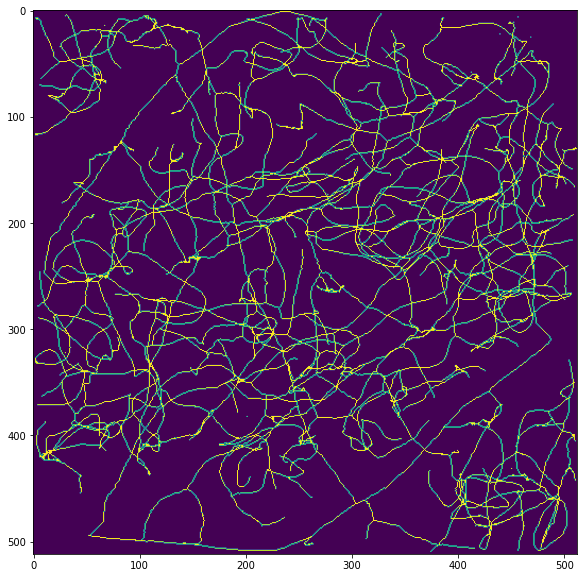

 50%|█████     | 1/2 [02:13<02:13, 133.82s/it]

1376
770


/tmp/ipykernel_453834/1448379817.py:27: UserWarning:

matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres029_single_skel.tif is a low contrast image



matched
matched
matched
matched
matched


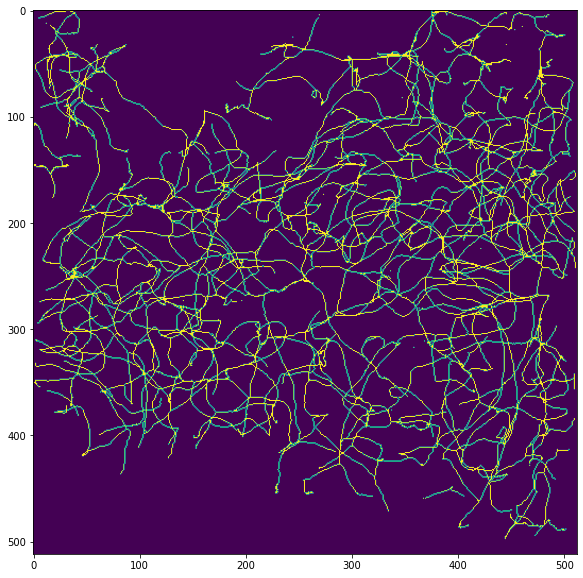

100%|██████████| 2/2 [04:33<00:00, 136.85s/it]


In [27]:
for file_0001 in tqdm(files_seg_0001[:]):
    #if not os.path.exists(re.sub('_warped_seg.npy','_warped.pickle',file_0001)): #or (time.time() - os.path.getmtime(re.sub('_warped_seg.npy','_warped.pickle',file_0001)))/3600>48:
        if os.path.exists(re.sub('_warped_seg.npy','_skel_warped_single.mat',file_0001)):
            file = file_0001
            skel_file = re.sub('_warped_seg.npy','_skel_warped_single.mat',file)
            skel = loadmat(skel_file)['FilteredImage']
            if np.sum(skel) != 0:
                graph = sknw.build_sknw(skel, multi=False)
                print(len(graph.edges))
                while len(list(nx.selfloop_edges(graph)))>0:
                    if len(list(nx.selfloop_edges(graph))) !=0:
                        for edge in list(nx.selfloop_edges(graph)):
                            skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                    for edge in graph.edges:
                        if (graph.degree(edge[0]) == 1 and graph.degree(edge[1]) > 2) or (graph.degree(edge[1]) == 1 and graph.degree(edge[0]) > 2):
                            if graph[edge[0]][edge[1]]['weight']<20:
                                skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                    graph = sknw.build_sknw(skel, multi=False)
                for edge in graph.edges:
                    if (graph.degree(edge[0]) == 1 and graph.degree(edge[1]) > 2) or (graph.degree(edge[1]) == 1 and graph.degree(edge[0]) > 2):
                        if graph[edge[0]][edge[1]]['weight']<20:
                            skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                graph = sknw.build_sknw(skel, multi=False)
                graph.remove_nodes_from(list(nx.isolates(graph)))
                print(len(graph.edges))
                #print(len(list(nx.isolates(graph))))
                io.imsave(re.sub('_warped_seg.npy','_single_skel.tif',file),skel)
                nx.write_gpickle(graph,re.sub('_warped_seg.npy','_warped.pickle',file))
                key = [x for x in list(dic.keys()) if x in file][0]
                mov_files = [re.sub(key,x,file) for x in dic[key]]
                mov_files = sorted(mov_files + [re.sub('_0001','',x) for x in mov_files])
                mov_files.append(re.sub('_0001','',file))
                seg = np.load(file)
                for _file in mov_files:
                    if os.path.exists(_file):
                        seg_0001 = np.load(_file)
                        _mut_info = normalized_mutual_info_score(seg.flatten(),seg_0001.flatten()) # calculate mutual information between masks, judges registration
                        if _mut_info > 0.1:
                            print('matched')
                            nx.write_gpickle(graph,re.sub('_warped_seg.npy','_warped.pickle',_file))
                plt.rcParams['figure.figsize'] = [10, 10]
                plt.imshow(np.max(skel,axis=2))
                plt.show()

In [40]:
res = []
for edge in graph.edges:
    res.append(np.mean(np.array(graph[edge[0]][edge[1]]['pts'])[:,2]))
max(res)

245.70909090909092

# write vessel measurments to graph files

In [20]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files = directory.glob('*_warped.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if '-' in x]
files = [x for x in files if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',x)))]
files = [x for x in files if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',x)))]
print(len(files))
print(files[0])

13
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_0001_warped.pickle


In [72]:
files

['matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_0001_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres298_0001_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres298_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres301_0001_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres301_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres302_0001_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres302_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres305_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20220713_76-XYZres463_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20220713_76-XYZres464_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20220713_76-XYZres465_warped.pickle',
 'matt_raw_warped_single_upsampled_seg/20220713_76-XYZre

In [44]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
for file in tqdm(files):
    if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file))):
        #print('yes')
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            print('yes')
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    #print('a')
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        if subj in ["TBI7_3D",
                                    "SHAM12_3D",
                                    "TBI11_3D",
                                    "SHAM9_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D',
                                    'SHAM68_3D']:
                            gender = 'male'
                        elif subj in ["TBI14_3D",
                                      "SHAM17_3D",
                                      "TBI18_3D",
                                      "SHAM20_3D",
                                      "TBI26_3D",
                                      "TBI28_3D",
                                      "SHAM35_3D",
                                      "TBI33_3D",
                                      "TBI40_3D",
                                      "SHAM4_3D",
                                      "TBI51_3D",
                                      "SHAM64_3D",
                                      "SHAM63_3D",
                                      "TBI61_3D",
                                      "TBI48_3D",
                                      "TBI49_3D",
                                      "SHAM67_3D",
                                      "TBI65_3D",
                                      "TBI70_3D",
                                      "SHAM73_3D"]:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]  
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            #print('yes')
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 14'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 15'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                
                                _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                
                                
                                res_fwhm = []
                                
                                res_fwhm_sigma = []
                                
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                        deconv_img,
                                                                        rotated.T, 
                                                                        order=3,
                                                                        mode='constant')
                                    
                                            
                                    points_img = np.reshape(points_img,(len(X),len(Y)))
                                    points_img_no_smooth = np.copy(points_img)
                                    points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)

                                    
                                    
                                    _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                    _zeros = np.zeros(len(_point))
                                    _point = np.array([_point,_zeros])
                                    _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                    
                                    _res = []
                                    
                                    fig,ax = plt.subplots(1)
                                    ax.set_aspect('equal')
                                    ax.imshow(points_img_no_smooth,
                                              vmin = 0,
                                              vmax = np.max(deconv_img))
                                    ax.scatter(_centre[0],_centre[1])
                                    for deg in np.arange(0,360,10):
                                        rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                        rot_point[0] = rot_point[0] + _centre[0]
                                        rot_point[1] = rot_point[1] + _centre[1]
                                        points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                 rot_point, 
                                                                                 order=3,
                                                                                 cval=0)
                                        points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                        points_vals_grad = np.gradient(points_vals)
                                        _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                        if _.shape[1] != 0:
                                            points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                        else:
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                    _res = np.array(_res)
                                    _res = _res[np.where(_res!=0)]
                                    _mean = np.mean(_res)
                                    _std = np.std(_res)
                                    _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                    _res = _res[_mask]
                                    radii = np.mean(_res)
                                    radii_std = np.std(_res)
                                    circ = Circle(_centre,radii,fill=False)
                                    #ax.add_patch(circ)
                                    ax.set_title(radii)
                                    fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                    plt.clf()
                                    
                                        
                                    return radii, radii_std
                                
                                pool = multiprocessing.Pool(8)
                                _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                images = []
                                for I in tqdm(range(len(path))):
                                    images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png'))
                                    os.remove('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)
                                
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['wavelength'] = wavelength
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['power'] = power_per
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                                break
                            break
                            #nx.write_gpickle(graph, re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file)))

  1%|          | 6/716 [00:00<00:12, 56.31it/s]

yes
yes
yes
yes
yes
yes
yes


  3%|▎         | 18/716 [00:00<00:15, 44.55it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


  4%|▍         | 32/716 [00:00<00:13, 51.70it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


  5%|▌         | 39/716 [00:00<00:13, 51.94it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


  7%|▋         | 51/716 [00:01<00:13, 48.39it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


  8%|▊         | 58/716 [00:01<00:13, 50.24it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes


 10%|▉         | 70/716 [00:01<00:14, 45.52it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


 11%|█         | 76/716 [00:01<00:13, 47.94it/s]

yes
yes
yes
yes
yes
yes
yes


 12%|█▏        | 86/716 [00:01<00:16, 37.18it/s]

yes
yes
yes
yes
yes
yes
yes


 13%|█▎        | 91/716 [00:02<00:18, 33.98it/s]

yes
yes
yes
yes


 13%|█▎        | 95/716 [00:02<00:24, 25.32it/s]

yes
yes
yes
yes
yes


 14%|█▍        | 101/716 [00:02<00:29, 20.88it/s]

yes
yes
yes
yes
yes


 15%|█▍        | 104/716 [00:02<00:31, 19.26it/s]

yes
yes
yes
yes
yes


 16%|█▌        | 111/716 [00:03<00:25, 23.46it/s]

yes
yes
yes
yes
yes
yes


 16%|█▋        | 117/716 [00:03<00:25, 23.70it/s]

yes
yes
yes
yes
yes


 17%|█▋        | 120/716 [00:03<00:29, 20.43it/s]

yes
yes
yes


 17%|█▋        | 123/716 [00:03<00:30, 19.14it/s]

yes
yes
yes
yes


 18%|█▊        | 126/716 [00:04<00:33, 17.67it/s]

yes
yes
yes
yes


 18%|█▊        | 131/716 [00:04<00:31, 18.51it/s]

yes
yes
yes


 19%|█▉        | 135/716 [00:04<00:32, 17.84it/s]

yes
yes
yes
yes


 19%|█▉        | 137/716 [00:04<00:34, 16.76it/s]

yes
yes
yes


 20%|█▉        | 142/716 [00:05<00:35, 16.29it/s]

yes
yes
yes
yes
yes


 20%|██        | 145/716 [00:05<00:34, 16.62it/s]

yes
yes
yes


 21%|██        | 150/716 [00:05<00:33, 16.94it/s]

yes
yes
yes
yes


 21%|██        | 152/716 [00:05<00:32, 17.40it/s]

yes
yes
yes
yes


 22%|██▏       | 157/716 [00:05<00:34, 16.27it/s]

yes
yes
yes


 22%|██▏       | 161/716 [00:06<00:34, 15.87it/s]

yes
yes
yes
yes


 23%|██▎       | 164/716 [00:06<00:31, 17.57it/s]

yes
yes
yes
yes
yes


 24%|██▎       | 170/716 [00:06<00:27, 19.56it/s]

yes
yes
yes
yes


 24%|██▍       | 172/716 [00:06<00:31, 17.30it/s]

yes
yes
yes
yes


 25%|██▍       | 178/716 [00:06<00:26, 20.27it/s]

yes
yes
yes
yes
yes


 25%|██▌       | 181/716 [00:07<00:32, 16.62it/s]

yes
yes
yes


 26%|██▌       | 186/716 [00:07<00:28, 18.76it/s]

yes
yes
yes
yes
yes


 27%|██▋       | 191/716 [00:07<00:30, 17.11it/s]

yes
yes
yes
yes


 27%|██▋       | 195/716 [00:08<00:29, 17.39it/s]

yes
yes
yes
yes
yes


 28%|██▊       | 198/716 [00:08<00:26, 19.24it/s]

yes
yes
yes


 28%|██▊       | 200/716 [00:08<00:31, 16.15it/s]

yes
yes
yes


 29%|██▊       | 205/716 [00:08<00:32, 15.64it/s]

yes
yes
yes
yes
yes


 29%|██▉       | 211/716 [00:08<00:25, 19.95it/s]

yes
yes
yes
yes
yes
yes
yes


 30%|███       | 216/716 [00:09<00:19, 25.08it/s]

yes
yes
yes
yes


 31%|███▏      | 224/716 [00:09<00:17, 27.73it/s]

yes
yes
yes
yes
yes
yes
yes


 32%|███▏      | 230/716 [00:09<00:20, 23.42it/s]

yes
yes
yes
yes
yes


 33%|███▎      | 233/716 [00:09<00:20, 23.71it/s]

yes
yes
yes


 33%|███▎      | 236/716 [00:09<00:24, 19.52it/s]

yes
yes
yes
yes
yes


 34%|███▎      | 241/716 [00:10<00:26, 18.05it/s]

yes
yes
yes


 34%|███▍      | 247/716 [00:10<00:22, 21.12it/s]

yes
yes
yes
yes
yes
yes


 35%|███▍      | 250/716 [00:10<00:21, 21.59it/s]

yes
yes
yes
yes
yes
yes
yes
yes


 36%|███▌      | 258/716 [00:10<00:19, 23.73it/s]

yes
yes
yes
yes
yes
yes
yes
yes


 38%|███▊      | 269/716 [00:11<00:13, 32.92it/s]

yes
yes
yes
yes
yes
yes
yes
yes


 38%|███▊      | 274/716 [00:11<00:12, 35.45it/s]

yes
yes
yes
yes
yes


 40%|███▉      | 283/716 [00:11<00:16, 25.52it/s]

yes
yes
yes
yes
yes
yes
yes


 40%|████      | 287/716 [00:12<00:17, 24.41it/s]

yes
yes
yes
yes
yes


 41%|████      | 293/716 [00:12<00:18, 23.21it/s]

yes
yes
yes
yes
yes
yes


 42%|████▏     | 304/716 [00:12<00:12, 34.01it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


 43%|████▎     | 311/716 [00:12<00:09, 41.27it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


 44%|████▍     | 316/716 [00:12<00:10, 39.66it/s]

yes
yes
yes
yes
yes


 45%|████▍     | 321/716 [00:13<00:12, 32.22it/s]

yes
yes
yes
yes
yes


 45%|████▌     | 325/716 [00:13<00:13, 28.34it/s]

yes
yes
yes


 46%|████▌     | 329/716 [00:13<00:17, 21.78it/s]

yes
yes
yes
yes


 47%|████▋     | 335/716 [00:13<00:18, 20.93it/s]

yes
yes
yes
yes


 48%|████▊     | 341/716 [00:14<00:17, 21.71it/s]

yes
yes
yes
yes
yes
yes


 48%|████▊     | 344/716 [00:14<00:19, 19.50it/s]

yes
yes
yes
yes


 48%|████▊     | 347/716 [00:14<00:18, 19.46it/s]

yes
yes
yes
yes


 49%|████▉     | 352/716 [00:14<00:19, 19.07it/s]

yes
yes
yes
yes


 50%|████▉     | 355/716 [00:14<00:15, 23.82it/s]

yes
yes


KeyboardInterrupt: 

In [45]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

for file in tqdm(files):
    if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',file))):
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        if _tmp['Unnamed: 12'].iloc[0] != 'raster':
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            current = _tmp['Unnamed: 10'].iloc[0]
                            freq = _tmp['Unnamed: 11'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 8'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 9'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                
                                _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                
                                
                                res_fwhm = []
                                
                                res_fwhm_sigma = []
                                
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                        deconv_img,
                                                                        rotated.T, 
                                                                        order=3,
                                                                        mode='constant')
                                    
                                            
                                    points_img = np.reshape(points_img,(len(X),len(Y)))
                                    points_img_no_smooth = np.copy(points_img)
                                    points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)

                                    
                                    
                                    _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                    _zeros = np.zeros(len(_point))
                                    _point = np.array([_point,_zeros])
                                    _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                    
                                    _res = []
                                    
                                    fig,ax = plt.subplots(1)
                                    ax.set_aspect('equal')
                                    ax.imshow(points_img_no_smooth,
                                              vmin = 0,
                                              vmax = np.max(deconv_img))
                                    ax.scatter(_centre[0],_centre[1])
                                    for deg in np.arange(0,360,10):
                                        rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                        rot_point[0] = rot_point[0] + _centre[0]
                                        rot_point[1] = rot_point[1] + _centre[1]
                                        points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                 rot_point, 
                                                                                 order=3,
                                                                                 cval=0)
                                        points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                        points_vals_grad = np.gradient(points_vals)
                                        _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                        if _.shape[1] != 0:
                                            points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                        else:
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                    _res = np.array(_res)
                                    _res = _res[np.where(_res!=0)]
                                    _mean = np.mean(_res)
                                    _std = np.std(_res)
                                    _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                    _res = _res[_mask]
                                    radii = np.mean(_res)
                                    radii_std = np.std(_res)
                                    circ = Circle(_centre,radii,fill=False)
                                    #ax.add_patch(circ)
                                    ax.set_title(radii)
                                    fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                    plt.clf()
                                    
                                        
                                    return radii, radii_std
                                
                                pool = multiprocessing.Pool(8)
                                _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                images = []
                                for I in tqdm(range(len(path))):
                                    images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png'))
                                    os.remove('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)
                                
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['current'] = current
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['frequency'] = freq
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            nx.write_gpickle(graph, re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',file)))

100%|██████████| 716/716 [00:29<00:00, 24.02it/s]


In [ ]:
os.remove(file)

# Get pickle files with vascular measurments

In [84]:
directory = Path('matt_preds_graphs_fwhm_single')
files = directory.glob('*_warped_radii.pickle')
files = sorted([x.as_posix() for x in files])
files2 = directory.glob('*_warped_radii_forepaw.pickle')
files2 = sorted([x.as_posix() for x in files2])
files += files2
files = [x for x in files if "vbm" in x]
print(len(files))
#files = [x for x in files if '45-' in x]
#print(sorted(files))

86


In [85]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
for file in tqdm(files[::-1]):
    graph = nx.read_gpickle(file)
    for sheet_name in xls.sheet_names + xls2.sheet_names:
        if re.sub('_0001','',re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped_radii.pickle','',re.sub('_warped_radii_forepaw.pickle','',re.sub('xyz','XYZ',file)))).split('-')[1]) in df[sheet_name].values:
            subj = sheet_name
            if (re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                scan = re.sub('_0001','',re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped_radii.pickle','',re.sub('_warped_radii_forepaw.pickle','',re.sub('xyz','XYZ',file)))).split('-')[1])
                _ = subj.split('_')[0]
                if subj in ["TBI7_3D",
                            "SHAM12_3D",
                            "TBI11_3D",
                            "SHAM9_3D",
                            "TBI22_3D",
                            "TBI31_3D",
                            "TBI38_3D",
                            "SHAM09_3D",
                            "SHAM23_3D",
                            "SHAM32_3D",
                            'TBI38_3D',
                            'TBI6_3D',
                            'SHAM7_3D',
                            'TBI43_3D',
                            'TBI45_3D',
                            'SHAM53_3D',
                            'SHAM56_3D',
                            'SHAM55_3D',
                            'SHAM68_3D',
                            "vbm04_3D",
                            "vbm05_3D",
                            "vbm06_3D",
                            "vbm08_3D",
                            "vbm10_3D",
                            "SHAM68_3D",
                            "SHAM76_3D",
                            "TBI77_3D",
                            "TBI80_3D",
                            "TBI78_3D", 
                            'SHAM81_3D']:
                    gender = 'male'
                elif subj in ["TBI14_3D",
                              "SHAM17_3D",
                              "TBI18_3D",
                              "SHAM20_3D",
                              "TBI26_3D",
                              "TBI28_3D",
                              "SHAM35_3D",
                              "TBI33_3D",
                              "TBI40_3D",
                              "SHAM4_3D",
                              "TBI51_3D",
                              "SHAM64_3D",
                              "SHAM63_3D",
                              "TBI61_3D",
                              "TBI48_3D",
                              "TBI49_3D",
                              "SHAM67_3D",
                              "TBI65_3D",
                              "TBI70_3D",
                              "SHAM73_3D",
                              "vbm01_3D",
                              "vbm02_3D",
                              "vbm03_3D",
                              "vbm07_3D",
                              "vbm09_3D",
                              "vbm11_3D"]:
                    gender = 'female'
                else:
                    gender = "NA"
                    print('no sex listed')
                    print(subj)
                
                if 'vbm' not in _:
                    seq_type = type(_)
                    dic_key = seq_type().join(filter(seq_type.isdigit,_)) + '-' + scan
                elif 'vbm' in _: 
                    dic_key = '-' + scan
                if dic_key in list(dic.keys()):
                    _tmp_df = df[subj].loc[df[subj]['CHECK WATER'] ==  scan]
                else:
                    for key in list(dic.keys()):
                        if dic_key in dic[key]:
                            _key = key
                            _scan = key.split('-')[1]
                            _tmp_df = df[subj].loc[df[subj]['CHECK WATER'] ==  _scan]
                if 'vbm' in _:
                    pre_weight = np.nan
                    post_weight = np.nan
                elif 'vbm' not in _:
                    pre_weight = float(_tmp_df['Unnamed: 16'])
                    post_weight = float(_tmp_df['Unnamed: 17'])
    nrn_dst = np.load(re.sub('preds_graphs_fwhm_single','raw_warped_single_upsampled_seg',re.sub('_warped_radii.pickle','_warped_seg_nrn_dst.npy',re.sub('_warped_radii_forepaw.pickle','_warped_seg_nrn_dst.npy',file))))
    _res = []
    for edge in graph.edges:
        path = graph[edge[0]][edge[1]]['pts']
        _res.append(np.mean(path[:,2]))
        _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
        if not graph[edge[0]][edge[1]]['mean_neuron_distance']==np.mean(_nrn_dst_vals):
            print('error')
            exit
        if np.isnan(graph[edge[0]][edge[1]]['radii']):
            _tmp = np.array(graph[edge[0]][edge[1]]['path_weights'])
            _tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))]
            graph[edge[0]][edge[1]]['radii'] = np.mean(_tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))])
            graph[edge[0]][edge[1]]['radii_std'] = np.std(_tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))])
        graph[edge[0]][edge[1]]['start_depth'] = _tmp_df['Unnamed: 2'].iloc[0]
        graph[edge[0]][edge[1]]['gender'] = gender
        graph[edge[0]][edge[1]]['mean_depth'] = np.mean(path[:,2])
        graph[edge[0]][edge[1]]['path_weights_nrn'] = _nrn_dst_vals
        graph[edge[0]][edge[1]]['start_weight'] = pre_weight
        graph[edge[0]][edge[1]]['imaging_weight'] = post_weight
            #print(_tmp_df['Unnamed: 2'].iloc[0])
    print(np.max(_res))
    #print(gender)
    #print(subj)
    #print(file)
    if subj == "SHAM73_3D" and graph[edge[0]][edge[1]]['gender'] == 'male':
        error
    nx.write_gpickle(graph, re.sub('.pickle','_amended.pickle',file))
re.sub('.pickle','_amended.pickle',file)

  0%|          | 0/86 [00:00<?, ?it/s]

245.72


  2%|▏         | 2/86 [00:02<01:33,  1.11s/it]

245.72
249.12280701754386


  3%|▎         | 3/86 [00:04<02:04,  1.51s/it]

249.12280701754386


  6%|▌         | 5/86 [00:06<01:46,  1.32s/it]

245.72


  7%|▋         | 6/86 [00:07<01:33,  1.16s/it]

245.72
249.12280701754386


  8%|▊         | 7/86 [00:09<02:02,  1.55s/it]

249.12280701754386


 10%|█         | 9/86 [00:11<01:25,  1.11s/it]

245.72


 12%|█▏        | 10/86 [00:12<01:25,  1.12s/it]

245.72
249.12280701754386


 13%|█▎        | 11/86 [00:13<01:36,  1.28s/it]

249.12280701754386


 15%|█▌        | 13/86 [00:16<01:35,  1.31s/it]

243.7942857142857


 16%|█▋        | 14/86 [00:18<01:40,  1.40s/it]

243.7942857142857


 17%|█▋        | 15/86 [00:19<01:31,  1.28s/it]

246.4561403508772
246.4561403508772


 20%|█▉        | 17/86 [00:21<01:16,  1.11s/it]

243.7942857142857


 21%|██        | 18/86 [00:21<01:02,  1.09it/s]

243.7942857142857
246.4561403508772


 23%|██▎       | 20/86 [00:24<01:07,  1.03s/it]

246.4561403508772


 24%|██▍       | 21/86 [00:24<01:05,  1.00s/it]

243.7942857142857


 26%|██▌       | 22/86 [00:25<00:55,  1.15it/s]

243.7942857142857


 27%|██▋       | 23/86 [00:26<00:49,  1.28it/s]

246.4561403508772
246.4561403508772


 29%|██▉       | 25/86 [00:28<01:02,  1.03s/it]

230.48535564853557


 30%|███       | 26/86 [00:29<00:53,  1.12it/s]

230.48535564853557
245.31578947368422


 31%|███▏      | 27/86 [00:29<00:47,  1.25it/s]

245.31578947368422


 34%|███▎      | 29/86 [00:31<00:54,  1.04it/s]

230.48535564853557


 35%|███▍      | 30/86 [00:32<00:46,  1.20it/s]

230.48535564853557


 36%|███▌      | 31/86 [00:32<00:40,  1.36it/s]

245.31578947368422


 37%|███▋      | 32/86 [00:33<00:37,  1.42it/s]

245.31578947368422


 38%|███▊      | 33/86 [00:34<00:40,  1.32it/s]

230.48535564853557


 40%|███▉      | 34/86 [00:35<00:47,  1.10it/s]

230.48535564853557


 41%|████      | 35/86 [00:37<00:54,  1.07s/it]

245.31578947368422


 42%|████▏     | 36/86 [00:38<00:54,  1.09s/it]

245.31578947368422
244.71428571428572


 44%|████▍     | 38/86 [00:39<00:39,  1.20it/s]

244.71428571428572
245.70909090909092


 45%|████▌     | 39/86 [00:40<00:36,  1.29it/s]

245.70909090909092


 48%|████▊     | 41/86 [00:42<00:37,  1.19it/s]

244.71428571428572


 49%|████▉     | 42/86 [00:42<00:31,  1.39it/s]

244.71428571428572


 50%|█████     | 43/86 [00:42<00:28,  1.53it/s]

245.70909090909092
245.70909090909092


 52%|█████▏    | 45/86 [00:44<00:24,  1.69it/s]

244.71428571428572


 53%|█████▎    | 46/86 [00:44<00:22,  1.82it/s]

244.71428571428572
245.70909090909092


 56%|█████▌    | 48/86 [00:46<00:26,  1.43it/s]

245.70909090909092
250.28481012658227


 58%|█████▊    | 50/86 [00:47<00:25,  1.43it/s]

250.28481012658227


 59%|█████▉    | 51/86 [00:48<00:22,  1.53it/s]

243.5
243.5


 62%|██████▏   | 53/86 [00:49<00:22,  1.44it/s]

250.28481012658227
250.28481012658227


 63%|██████▎   | 54/86 [00:50<00:20,  1.57it/s]

243.5


 65%|██████▌   | 56/86 [00:51<00:21,  1.42it/s]

243.5


 66%|██████▋   | 57/86 [00:52<00:18,  1.54it/s]

231.4


 67%|██████▋   | 58/86 [00:52<00:16,  1.69it/s]

231.4


 69%|██████▊   | 59/86 [00:53<00:14,  1.83it/s]

241.63917525773195


 70%|██████▉   | 60/86 [00:53<00:12,  2.01it/s]

241.63917525773195


 71%|███████   | 61/86 [00:54<00:14,  1.74it/s]

231.4
231.4


 73%|███████▎  | 63/86 [00:55<00:14,  1.64it/s]

241.63917525773195


 74%|███████▍  | 64/86 [00:56<00:13,  1.59it/s]

241.63917525773195


 76%|███████▌  | 65/86 [00:56<00:12,  1.64it/s]

231.4
231.4


 78%|███████▊  | 67/86 [00:58<00:14,  1.32it/s]

241.63917525773195


 79%|███████▉  | 68/86 [00:59<00:13,  1.31it/s]

241.63917525773195
228.56363636363636


 81%|████████▏ | 70/86 [01:01<00:14,  1.11it/s]

228.56363636363636
250.7


 83%|████████▎ | 71/86 [01:02<00:12,  1.21it/s]

250.7


 85%|████████▍ | 73/86 [01:03<00:09,  1.31it/s]

228.56363636363636
228.56363636363636


 86%|████████▌ | 74/86 [01:04<00:09,  1.22it/s]

250.7


 87%|████████▋ | 75/86 [01:05<00:09,  1.21it/s]

250.7


 90%|████████▉ | 77/86 [01:06<00:06,  1.38it/s]

228.56363636363636
228.56363636363636


 91%|█████████ | 78/86 [01:06<00:05,  1.52it/s]

250.7


 92%|█████████▏| 79/86 [01:07<00:05,  1.36it/s]

250.7


 94%|█████████▍| 81/86 [01:09<00:03,  1.46it/s]

249.2608695652174


 95%|█████████▌| 82/86 [01:09<00:02,  1.41it/s]

249.2608695652174


 97%|█████████▋| 83/86 [01:10<00:02,  1.48it/s]

249.45833333333334
249.45833333333334


 98%|█████████▊| 84/86 [01:11<00:01,  1.33it/s]

249.45833333333334


100%|██████████| 86/86 [01:12<00:00,  1.18it/s]

249.45833333333334


'matt_preds_graphs_fwhm_single/vbm03 Feb 26 2020-XYZres006_0001_warped_radii_amended.pickle'

In [57]:
#

In [58]:
#graph[0][12]

In [90]:
(re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1]

'68'

In [ ]:
re.sub('preds_graphs_fwhm_single','raw_warped_single_upsampled_seg',re.sub('_warped_radii.pickle','_warped_seg_nrn_dst.npy',file))

# Grab labels from James labelled AVC for his data

In [86]:
folder = Path("matt_preds_graphs_fwhm_single")
files = list(folder.glob("*_amended.pickle"))
files = [x.as_posix() for x in files]
files = [x for x in files if "vbm" in x]
files = [x for x in files if "XYZres006" not in x]
print(len(files))
folder2 = Path("../../data/James_labelling_AVC/james_preds/")
files2 = list(folder2.glob("*_AVC.pickle"))
files2 = sorted([x.as_posix() for x in files2])

print(len(files2))
print(files2[0:5])

84
44
['../../data/James_labelling_AVC/james_preds/XYZres007_warped_single_radii_matched_AVC.pickle', '../../data/James_labelling_AVC/james_preds/XYZres008_warped_single_radii_matched_AVC.pickle', '../../data/James_labelling_AVC/james_preds/XYZres009_warped_single_radii_matched_AVC.pickle', '../../data/James_labelling_AVC/james_preds/XYZres010_warped_single_radii_matched_AVC.pickle', '../../data/James_labelling_AVC/james_preds/XYZres011_warped_single_radii_matched_AVC.pickle']


In [63]:
print(files[0:5])

['matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres014_0001_warped_radii_amended.pickle', 'matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres028_warped_radii_amended.pickle', 'matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres017_warped_radii_amended.pickle', 'matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres015_warped_radii_amended.pickle', 'matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres033_warped_radii_amended.pickle']


In [16]:
[x for x in files2 if scan in x]

[]

In [98]:
for file in tqdm(files):
    graph_1 = nx.read_gpickle(file)
    scan = file.split('-')[1].split('_')[0]
    res = np.array([[0,0,0]])
    if len([x for x in files2 if scan in x]) == 1:
        keys = list(dic.keys())
        keys = [re.sub('-','',x) for x in keys if len(x) == 10] + ['XYZres007']
        if any(y in [x for x in files2 if scan in x][0] for y in keys):
            AVC_file = [x for x in files2 if scan in x][0]
        else:
            for key in list(dic.keys()):
                if any(y in file for y in dic[key]):
                    _file = re.sub(np.array(dic[key])[np.array([y in file for y in dic[key]])][0],key,file)
                    _scan = _file.split('-')[1].split('_')[0]
                    AVC_file = [x for x in files2 if _scan in x][0]
        graph_AVC = nx.read_gpickle(AVC_file)
        skel_1 = np.zeros((252,507,507))
        mask_1 = np.zeros((252,507,507))
        for edge in graph_AVC.edges:
            pts = graph_AVC[edge[0]][edge[1]]['pts']
            #res = np.concatenate((res,pts),axis=0)
            skel_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]] = graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1
            pts = graph_AVC[edge[0]][edge[1]]['pts_0001']
            skel_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]] = graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1
            #print(graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1)
        for i in [3,2,1]:
            mask_1[binary_dilation(skel_1==i, iterations=5)] = i
        mask_1 = resize(mask_1,(254,512,512),order=0)
        mask_1 = np.swapaxes(mask_1,0,2)
        for edge in graph_1.edges:
            pts = graph_1[edge[0]][edge[1]]['pts']
            #res = np.concatenate((res,pts),axis=0)
            AVC = mask_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]]
            mean = np.mean(AVC[AVC!=0])
            if ~np.isnan(mean) and mean//1 == mean:
                graph_1[edge[0]][edge[1]]['A_V_C'] = mean - 1
            elif np.isnan(mean):
                graph_1[edge[0]][edge[1]]['A_V_C'] = 2
            else:
                _mode = mode(AVC)
                if _mode != 0:
                    graph_1[edge[0]][edge[1]]['A_V_C'] = _mode - 1
                else:
                    graph_1[edge[0]][edge[1]]['A_V_C'] = 2
        #print(np.max(nx.to_pandas_edgelist(graph)['mean_depth']))
        nx.write_gpickle(graph_1, re.sub('.pickle','_AVC.pickle',file))
        #print(np.max(res,axis=0))

100%|██████████| 84/84 [05:39<00:00,  4.04s/it]


In [95]:
np.max(nx.to_pandas_edgelist(graph)['mean_depth'])

249.45833333333334

In [33]:
re.sub('.pickle','_AVC.pickle',file)

'matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres014_0001_warped_radii_amended_AVC.pickle'

# Get Graphs

In [66]:
graph_folder = Path('matt_preds_graphs_fwhm_single')
graphs = sorted(list(graph_folder.glob("*_amended.pickle")))
graphs = [x.as_posix() for x in graphs]
print(graphs[0])
print(len(graphs))

matt_preds_graphs_fwhm_single/06162021_45-XYZres288_0001_warped_radii_amended.pickle
716


In [99]:
graph_folder = Path('matt_preds_graphs_fwhm_single')
graphs = sorted(list(graph_folder.glob("*_amended_AVC.pickle")))
graphs = [x.as_posix() for x in graphs]
graph = 0
print(graphs[0])
print(len(graphs))
for file in tqdm(graphs):
    del graph
    graph = nx.read_gpickle(file)
    edges = list(graph.edges)
    for i in range(len(edges)):
        if graph[edges[i][0]][edges[i][1]]['A_V_C'] == 0:
            graph[edges[i][0]][edges[i][1]]['branch order'] = 0
        else:
            graph[edges[i][0]][edges[i][1]]['branch order'] = 'NA'
    edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order'] == 0 ]
    order = 1
    while len(edges_start) != 0:
        for edge in edges_start:
            neighbors = [x for x in graph.neighbors(edge[0]) if x != edge[1]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[0]][i]['branch order'] == 'NA' and graph[edge[0]][i]['A_V_C'] != 1:
                        graph[edge[0]][i]['branch order'] = order
            neighbors = [x for x in graph.neighbors(edge[1]) if x != edge[0]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[1]][i]['branch order'] == 'NA':
                        graph[edge[1]][i]['branch order'] = order
        edges_start = []
        edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order'] == order ]
        order += 1
        #print(order)
    
    #######################################################################
    # Vein order
    #######################################################################
    
    for i in range(len(edges)):
        if graph[edges[i][0]][edges[i][1]]['A_V_C'] == 1:
            graph[edges[i][0]][edges[i][1]]['branch order from vein'] = 0
        else:
            graph[edges[i][0]][edges[i][1]]['branch order from vein'] = 'NA'
    edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order from vein'] == 0 ]
    order = -1
    while len(edges_start) != 0:
        for edge in edges_start:
            neighbors = [x for x in graph.neighbors(edge[0]) if x != edge[1]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[0]][i]['branch order from vein'] == 'NA' and graph[edge[0]][i]['A_V_C'] != 0:
                        graph[edge[0]][i]['branch order from vein'] = order
            neighbors = [x for x in graph.neighbors(edge[1]) if x != edge[0]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[1]][i]['branch order from vein'] == 'NA':
                        graph[edge[1]][i]['branch order from vein'] = order
        edges_start = []
        edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order from vein'] == order ]
        order -= 1
        #print(order)
    
    
    df = nx.to_pandas_edgelist(graph)
    print(np.max(nx.to_pandas_edgelist(graph)['mean_depth']))
    df.to_excel(re.sub('.pickle','_with_branch_order.xlsx',file))
    nx.write_gpickle(graph,re.sub('.pickle','_with_branch_order.pickle',file))
    #print(len(graph.edges))

matt_preds_graphs_fwhm_single/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC.pickle
84


  0%|          | 0/84 [00:00<?, ?it/s]

249.45833333333334


  1%|          | 1/84 [00:01<02:14,  1.61s/it]

249.45833333333334


  2%|▏         | 2/84 [00:02<01:59,  1.45s/it]

249.2608695652174


  4%|▎         | 3/84 [00:04<01:47,  1.33s/it]

249.2608695652174


  5%|▍         | 4/84 [00:08<03:25,  2.56s/it]

250.7


  6%|▌         | 5/84 [00:10<02:52,  2.19s/it]

250.7


  7%|▋         | 6/84 [00:11<02:37,  2.02s/it]

228.56363636363636


  8%|▊         | 7/84 [00:13<02:16,  1.77s/it]

228.56363636363636


 10%|▉         | 8/84 [00:14<02:04,  1.64s/it]

250.7


 11%|█         | 9/84 [00:16<02:07,  1.69s/it]

250.7


 12%|█▏        | 10/84 [00:17<02:01,  1.65s/it]

228.56363636363636


 13%|█▎        | 11/84 [00:19<01:55,  1.58s/it]

228.56363636363636


 14%|█▍        | 12/84 [00:20<01:47,  1.49s/it]

250.7


 15%|█▌        | 13/84 [00:22<01:49,  1.54s/it]

250.7


 17%|█▋        | 14/84 [00:23<01:49,  1.56s/it]

228.56363636363636


 18%|█▊        | 15/84 [00:25<01:46,  1.54s/it]

228.56363636363636


 19%|█▉        | 16/84 [00:26<01:39,  1.46s/it]

241.63917525773195


 20%|██        | 17/84 [00:27<01:22,  1.23s/it]

241.63917525773195


 21%|██▏       | 18/84 [00:28<01:14,  1.14s/it]

231.4


 23%|██▎       | 19/84 [00:29<01:15,  1.16s/it]

231.4


 24%|██▍       | 20/84 [00:30<01:14,  1.16s/it]

241.63917525773195


 25%|██▌       | 21/84 [00:31<01:10,  1.11s/it]

241.63917525773195


 26%|██▌       | 22/84 [00:32<01:02,  1.01s/it]

231.4


 27%|██▋       | 23/84 [00:33<01:04,  1.05s/it]

231.4


 29%|██▊       | 24/84 [00:34<01:06,  1.11s/it]

241.63917525773195


 30%|██▉       | 25/84 [00:35<00:59,  1.00s/it]

241.63917525773195


 31%|███       | 26/84 [00:36<00:53,  1.09it/s]

231.4


 32%|███▏      | 27/84 [00:37<00:56,  1.01it/s]

231.4


 33%|███▎      | 28/84 [00:38<00:59,  1.07s/it]

243.5


 35%|███▍      | 29/84 [00:39<01:03,  1.16s/it]

243.5


 36%|███▌      | 30/84 [00:41<01:09,  1.28s/it]

250.28481012658227


 37%|███▋      | 31/84 [00:42<01:06,  1.26s/it]

250.28481012658227


 38%|███▊      | 32/84 [00:44<01:07,  1.30s/it]

243.5


 39%|███▉      | 33/84 [00:45<01:08,  1.34s/it]

243.5


 40%|████      | 34/84 [00:47<01:10,  1.40s/it]

250.28481012658227


 42%|████▏     | 35/84 [00:48<01:06,  1.35s/it]

250.28481012658227


 43%|████▎     | 36/84 [00:49<01:02,  1.31s/it]

245.70909090909092


 44%|████▍     | 37/84 [00:51<01:06,  1.41s/it]

245.70909090909092


 45%|████▌     | 38/84 [00:52<01:07,  1.48s/it]

244.71428571428572


 46%|████▋     | 39/84 [00:54<01:03,  1.41s/it]

244.71428571428572


 48%|████▊     | 40/84 [00:55<00:59,  1.35s/it]

245.70909090909092


 49%|████▉     | 41/84 [00:56<01:02,  1.45s/it]

245.70909090909092


 50%|█████     | 42/84 [00:58<01:04,  1.53s/it]

244.71428571428572


 51%|█████     | 43/84 [00:59<00:58,  1.44s/it]

244.71428571428572


 52%|█████▏    | 44/84 [01:01<00:56,  1.40s/it]

245.70909090909092


 54%|█████▎    | 45/84 [01:02<00:57,  1.47s/it]

245.70909090909092


 55%|█████▍    | 46/84 [01:04<00:58,  1.53s/it]

244.71428571428572


 56%|█████▌    | 47/84 [01:05<00:53,  1.44s/it]

244.71428571428572


 57%|█████▋    | 48/84 [01:07<00:50,  1.40s/it]

245.31578947368422


 58%|█████▊    | 49/84 [01:08<00:46,  1.34s/it]

245.31578947368422


 60%|█████▉    | 50/84 [01:09<00:45,  1.33s/it]

230.48535564853557


 61%|██████    | 51/84 [01:10<00:41,  1.25s/it]

230.48535564853557


 62%|██████▏   | 52/84 [01:11<00:38,  1.21s/it]

245.31578947368422


 63%|██████▎   | 53/84 [01:13<00:38,  1.25s/it]

245.31578947368422


 64%|██████▍   | 54/84 [01:14<00:36,  1.23s/it]

230.48535564853557


 65%|██████▌   | 55/84 [01:15<00:36,  1.27s/it]

230.48535564853557


 67%|██████▋   | 56/84 [01:16<00:33,  1.21s/it]

245.31578947368422


 68%|██████▊   | 57/84 [01:17<00:33,  1.23s/it]

245.31578947368422


 69%|██████▉   | 58/84 [01:19<00:33,  1.27s/it]

230.48535564853557


 70%|███████   | 59/84 [01:20<00:30,  1.20s/it]

230.48535564853557


 71%|███████▏  | 60/84 [01:21<00:29,  1.23s/it]

246.4561403508772


 73%|███████▎  | 61/84 [01:23<00:29,  1.27s/it]

246.4561403508772


 74%|███████▍  | 62/84 [01:24<00:29,  1.32s/it]

243.7942857142857


 75%|███████▌  | 63/84 [01:25<00:25,  1.23s/it]

243.7942857142857


 76%|███████▌  | 64/84 [01:26<00:23,  1.17s/it]

246.4561403508772


 77%|███████▋  | 65/84 [01:27<00:23,  1.26s/it]

246.4561403508772


 79%|███████▊  | 66/84 [01:29<00:22,  1.28s/it]

243.7942857142857


 80%|███████▉  | 67/84 [01:30<00:21,  1.24s/it]

243.7942857142857


 81%|████████  | 68/84 [01:31<00:18,  1.17s/it]

246.4561403508772


 82%|████████▏ | 69/84 [01:32<00:18,  1.26s/it]

246.4561403508772


 83%|████████▎ | 70/84 [01:34<00:17,  1.26s/it]

243.7942857142857


 85%|████████▍ | 71/84 [01:35<00:15,  1.19s/it]

243.7942857142857


 86%|████████▌ | 72/84 [01:36<00:14,  1.19s/it]

249.12280701754386


 87%|████████▋ | 73/84 [01:38<00:15,  1.42s/it]

249.12280701754386


 88%|████████▊ | 74/84 [01:40<00:15,  1.52s/it]

245.72


 89%|████████▉ | 75/84 [01:41<00:13,  1.51s/it]

245.72


 90%|█████████ | 76/84 [01:43<00:11,  1.49s/it]

249.12280701754386


 92%|█████████▏| 77/84 [01:44<00:11,  1.62s/it]

249.12280701754386


 93%|█████████▎| 78/84 [01:46<00:10,  1.72s/it]

245.72


 94%|█████████▍| 79/84 [01:48<00:08,  1.62s/it]

245.72


 95%|█████████▌| 80/84 [01:49<00:06,  1.59s/it]

249.12280701754386


 96%|█████████▋| 81/84 [01:51<00:05,  1.68s/it]

249.12280701754386


 98%|█████████▊| 82/84 [01:53<00:03,  1.73s/it]

245.72


 99%|█████████▉| 83/84 [01:55<00:01,  1.66s/it]

245.72


100%|██████████| 84/84 [01:56<00:00,  1.39s/it]


# Combine graphs into single pickle files

In [137]:
directory_seg = Path('matt_raw_warped_single_upsampled_seg')
images = list(directory_seg.glob('*_0001_warped_seg.npy'))
#print(len(images))
images = sorted([x.as_posix() for x in images])
#print(len(images))
images = [x for x in images if os.path.exists(re.sub('_0001','',x))]
#print(len(images))
images = [x for x in images if  any(y in x for y in list(dic.keys()))]
images = [re.sub('_0001','',x) for x in images]
images = [x for x in images if '51-XYZres297' not in x]
#images = [x for x in images if '_73' in x]
#images = [x for x in images if 'vbm']
images = [x for x in images if 'vbm' in x]
print(len(images))
images = [x for x in images if '006' not in x]
print(images)
#print(len(images))
directory = Path('matt_preds_graphs_fwhm_single')
files = directory.glob('*_amended.pickle')
files = directory.glob('*_with_branch_order.pickle')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if '_73' in x]
print(len(files))
print(files[0])

17
['matt_raw_warped_single_upsampled_seg/vbm03 Feb 26 2020-XYZres007_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm03 Feb 26 2020-XYZres008_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm04 Feb 27 2020-XYZres010_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm04 Feb 27 2020-XYZres011_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm05 Feb 28 2020-XYZres016_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm05 Feb 28 2020-XYZres017_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm07 Mar 24 2020-XYZres022_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm07 Mar 24 2020-XYZres023_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres028_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres029_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm09 Mar 28 2020-XYZres034_warped_seg.npy', 'matt_raw_warped_single_upsampled_seg/vbm09 Mar 28 2020-XYZres035_warped_seg.npy', 

In [116]:
os.path.exists(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))

True

In [117]:
image

'matt_raw_warped_single_upsampled_seg/vbm04 Feb 27 2020-XYZres010_0001_warped_seg.npy'

In [143]:
pool=0
del pool

In [144]:
res = []
ID = 0
mut_info = []
mut_info_fin = []
for image in tqdm(images[:]):
    img = np.load(image)
    _img = np.copy(img)
    img2 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
    _img2 = np.copy(img2)
    if os.path.exists(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    elif os.path.exists(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    else:
        print('error')
        break
    base_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',image)).split('-')[-1]
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['vessel_id'] = ID
        graph[edge[0]][edge[1]]['scan'] = base_scan
        ID += 1
    print(base_scan)
    print(np.max(nx.to_pandas_edgelist(graph)['mean_depth']))
    nx.write_gpickle(graph,re.sub('.pickle','_AVC_with_branch_order.pickle',re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image)))
    #print(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single_excel',image)))
    key = [x for x in list(dic.keys()) if x in image][0]
    mov_files = [re.sub(key,x,image) for x in dic[key]]
    mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
    mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
    mov_files = [x for x in mov_files if x != image]
    mov_files = sorted(mov_files)
    mov_files = np.unique(mov_files)
    mov_files = [x for x in mov_files if os.path.exists(x)]
    def process_file(i):
        img_0001 = np.load(i)
        img2_0001 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
        _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
        mut_info.append(_mut_info)
        if _mut_info > 0.05 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
            graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            print([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
            for edge in graph.edges:
                graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
                graph_0001[edge[0]][edge[1]]['scan'] = re.sub('_0001','',followup_scan)
            #print(graph_0001[edge[0]][edge[1]]['gender'] + graph_0001[edge[0]][edge[1]]['scan'])
            print(np.max(nx.to_pandas_edgelist(graph_0001)['mean_depth']))
            nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
            print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
        return _mut_info
    pool = multiprocessing.Pool(16)
    #pool.map(process_file, mov_files)
    mut_info = pool.map(process_file, mov_files)
    mut_info_fin.extend(mut_info)
    #for i in mov_files:
    #    img_0001 = np.load(i)
    #    _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
    #    mut_info.append(_mut_info)
    #    if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
    #        graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
    #        followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
    #        for edge in graph.edges:
    #            graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
    #            graph_0001[edge[0]][edge[1]]['scan'] = followup_scan
    #        nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    #        print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
print(ID)

  0%|          | 0/16 [00:00<?, ?it/s]

XYZres007
249.45833333333334
matt_preds_graphs_fwhm_single/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC_with_branch_order.pickle
249.45833333333334
matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC_with_branch_order.pickle


  6%|▋         | 1/16 [00:18<04:32, 18.18s/it]

XYZres008
249.2608695652174
matt_preds_graphs_fwhm_single/vbm03 Feb 26 2020-XYZres008_0001_warped_radii_amended_AVC_with_branch_order.pickle
249.2608695652174
matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres008_0001_warped_radii_amended_AVC_with_branch_order.pickle


 12%|█▎        | 2/16 [00:36<04:14, 18.16s/it]

XYZres010
228.56363636363636
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres014_0001_warped_radii_amended_AVC_with_branch_order.picklematt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres010_0001_warped_radii_amended_AVC_with_branch_order.picklematt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres014_warped_radii_amended_AVC_with_branch_order.picklematt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres012_0001_warped_radii_amended_AVC_with_branch_order.pickle


matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres012_warped_radii_amended_AVC_with_branch_order.pickle

228.56363636363636228.56363636363636228.56363636363636228.56363636363636
228.56363636363636



matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres012_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres010_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres012_warped_radii_amende

 19%|█▉        | 3/16 [01:02<04:45, 21.97s/it]

XYZres011
250.7
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres009_0001_warped_radii_amended_AVC_with_branch_order.pickle
250.7
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres013_warped_radii_amended_AVC_with_branch_order.pickle
250.7
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres009_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres009_warped_radii_amended_AVC_with_branch_order.pickle
250.7
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres013_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres009_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres011_0001_warped_radii_amended_AVC_with_branch_order.pickle
250.7
matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres013_0001_warped_radii_amended_AVC_with_branch_order.pickle
250.7
matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 202

 25%|██▌       | 4/16 [01:23<04:18, 21.57s/it]

XYZres016
231.4
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres018_warped_radii_amended_AVC_with_branch_order.pickle
231.4
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres018_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres020_0001_warped_radii_amended_AVC_with_branch_order.pickle
231.4
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres016_0001_warped_radii_amended_AVC_with_branch_order.pickle
231.4
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres020_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres020_0001_warped_radii_amended_AVC_with_branch_order.pickle
231.4
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres016_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres020_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZr

 31%|███▏      | 5/16 [01:45<03:56, 21.47s/it]

XYZres017
241.63917525773195
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres015_warped_radii_amended_AVC_with_branch_order.pickle
241.63917525773195
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres015_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres019_warped_radii_amended_AVC_with_branch_order.pickle
241.63917525773195
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres019_0001_warped_radii_amended_AVC_with_branch_order.pickle
241.63917525773195
matt_preds_graphs_fwhm_single/vbm05 Feb 28 2020-XYZres017_0001_warped_radii_amended_AVC_with_branch_order.picklematt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres019_warped_radii_amended_AVC_with_branch_order.pickle

241.63917525773195
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres019_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm05 Feb 28 2020-XYZres017_0001_warped_radii_amended_AVC_with_branch_

 38%|███▊      | 6/16 [02:05<03:29, 20.98s/it]

XYZres022
250.28481012658227
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres022_0001_warped_radii_amended_AVC_with_branch_order.pickle
250.28481012658227
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres022_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres024_warped_radii_amended_AVC_with_branch_order.pickle
250.28481012658227
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres024_0001_warped_radii_amended_AVC_with_branch_order.pickle
250.28481012658227
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres024_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres024_0001_warped_radii_amended_AVC_with_branch_order.pickle


 44%|████▍     | 7/16 [02:25<03:06, 20.74s/it]

XYZres023
243.5
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres021_0001_warped_radii_amended_AVC_with_branch_order.pickle
243.5
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres021_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres023_0001_warped_radii_amended_AVC_with_branch_order.pickle
243.5
matt_preds_graphs_fwhm_single/vbm07 Mar 24 2020-XYZres021_warped_radii_amended_AVC_with_branch_order.pickle
243.5
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres023_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres021_warped_radii_amended_AVC_with_branch_order.pickle


 50%|█████     | 8/16 [02:45<02:43, 20.44s/it]

XYZres028
244.71428571428572
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres032_warped_radii_amended_AVC_with_branch_order.pickle
244.71428571428572
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres030_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres032_warped_radii_amended_AVC_with_branch_order.pickle
244.71428571428572
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres030_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres028_0001_warped_radii_amended_AVC_with_branch_order.pickle
244.71428571428572
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres030_warped_radii_amended_AVC_with_branch_order.pickle
244.71428571428572
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres030_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres032_0001_warped_radii_amended_AVC_with_branch_order.

 56%|█████▋    | 9/16 [03:06<02:24, 20.61s/it]

XYZres029
245.70909090909092
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres031_warped_radii_amended_AVC_with_branch_order.pickle
245.70909090909092
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres031_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres027_warped_radii_amended_AVC_with_branch_order.pickle
245.70909090909092
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres029_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.70909090909092
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres027_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.70909090909092
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres027_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm08 Mar 27 2020-XYZres029_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm08 Mar 27 2020-XYZres031_0001_warped_radii_amended_AVC_with_branch_order.

 62%|██████▎   | 10/16 [03:26<02:03, 20.64s/it]

XYZres034
230.48535564853557
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres038_0001_warped_radii_amended_AVC_with_branch_order.pickle
230.48535564853557
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres036_warped_radii_amended_AVC_with_branch_order.pickle
230.48535564853557
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres038_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres036_0001_warped_radii_amended_AVC_with_branch_order.pickle
230.48535564853557
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres036_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres036_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres034_0001_warped_radii_amended_AVC_with_branch_order.pickle
230.48535564853557
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres038_warped_radii_amended_AVC_with_branch_o

 69%|██████▉   | 11/16 [03:47<01:43, 20.67s/it]

XYZres035
245.31578947368422
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres033_warped_radii_amended_AVC_with_branch_order.pickle
245.31578947368422
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres037_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres037_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres033_warped_radii_amended_AVC_with_branch_order.pickle
245.31578947368422
245.31578947368422
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres033_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.31578947368422
matt_preds_graphs_fwhm_single/vbm09 Mar 28 2020-XYZres035_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres037_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.31578947368422
matt_preds_graphs_fwhm_single_excel/vbm09 Mar 28 2020-XYZres037_warped_radii_amended_AVC

 75%|███████▌  | 12/16 [04:08<01:22, 20.60s/it]

XYZres040
243.7942857142857
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres040_0001_warped_radii_amended_AVC_with_branch_order.pickle
243.7942857142857
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres040_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres042_warped_radii_amended_AVC_with_branch_order.pickle
243.7942857142857
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres044_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres042_warped_radii_amended_AVC_with_branch_order.pickle
243.7942857142857
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres042_0001_warped_radii_amended_AVC_with_branch_order.pickle
243.7942857142857
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres044_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres042_0001_warped_radii_amended_AVC_with_branch_order

 81%|████████▏ | 13/16 [04:28<01:01, 20.62s/it]

XYZres041
246.4561403508772
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres043_0001_warped_radii_amended_AVC_with_branch_order.pickle
246.4561403508772
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres043_warped_radii_amended_AVC_with_branch_order.pickle
246.4561403508772
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres043_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres043_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres039_warped_radii_amended_AVC_with_branch_order.pickle
246.4561403508772
matt_preds_graphs_fwhm_single_excel/vbm10 Apr 03 2020-XYZres039_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres039_0001_warped_radii_amended_AVC_with_branch_order.pickle
246.4561403508772
matt_preds_graphs_fwhm_single/vbm10 Apr 03 2020-XYZres041_0001_warped_radii_amended_AVC_with_branch_order.pickl

 88%|████████▊ | 14/16 [04:51<00:42, 21.32s/it]

XYZres047
245.72
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres047_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.72
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres047_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres049_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres051_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.72
245.72
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres051_warped_radii_amended_AVC_with_branch_order.pickle
245.72
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres049_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres049_0001_warped_radii_amended_AVC_with_branch_order.pickle
245.72
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres051_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm11

 94%|█████████▍| 15/16 [05:12<00:21, 21.07s/it]

XYZres048
249.12280701754386
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres048_0001_warped_radii_amended_AVC_with_branch_order.pickle
249.12280701754386
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres048_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres050_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres046_0001_warped_radii_amended_AVC_with_branch_order.pickle
249.12280701754386
249.12280701754386
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres046_warped_radii_amended_AVC_with_branch_order.pickle
249.12280701754386
matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres050_warped_radii_amended_AVC_with_branch_order.pickle
249.12280701754386
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres050_0001_warped_radii_amended_AVC_with_branch_order.pickle
matt_preds_graphs_fwhm_single_excel/vbm11 Apr 04 2020-XYZres046_0001_warped_radii_a

100%|██████████| 16/16 [05:32<00:00, 20.81s/it]

9173


In [141]:
re.sub('.pickle','_AVC_with_branch_order.pickle',re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image))

'matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres011_warped_radii_amended_AVC_with_branch_order.pickle'

In [ ]:
#res = []
#ID = 0
#mut_info_fin = []
#for image in tqdm(images[:]):
#    img = np.load(image)
#    _img = np.copy(img)
#    img2 = np.load(re.sub('_seg','',image))
#    _img2 = np.copy(img2)
#    if os.path.exists(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
#        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
#        _image = re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
#    elif os.path.exists(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
#        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
#        _image = re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
#    else:
#        print('error')
#        break
#    base_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',image)).split('-')[-1]
#    for edge in graph.edges:
#        graph[edge[0]][edge[1]]['vessel_id'] = ID
#        graph[edge[0]][edge[1]]['scan'] = base_scan
#        ID += 1
#    nx.write_gpickle(graph,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image))
#    print(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single_excel',image)))
#    key = [x for x in list(dic.keys()) if x in image][0]
#    mov_files = [re.sub(key,x,image) for x in dic[key]]
#    mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
#    mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
#    mov_files = [x for x in mov_files if x != image]
#    mov_files = sorted(mov_files)
#    mov_files = np.unique(mov_files)
#    mov_files = [x for x in mov_files if os.path.exists(x)]
#    def process_file(i):
#        img_0001 = np.load(i)
#        img2_0001 = np.load(re.sub('_seg','',image))
#        _mut_info = normalized_mutual_info_score(_img2.flatten(),img2_0001.flatten()) # calculate mutual information between masks, judges registration
#        mut_info.append(_mut_info)
#        if _mut_info > 0 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
#            graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
#            followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
#            for edge in graph.edges:
#                graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
#                graph_0001[edge[0]][edge[1]]['scan'] = re.sub('_0001','',followup_scan)
#            nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
#        return _mut_info
#    pool = multiprocessing.Pool(32)
#    #pool.map(process_file, mov_files)
#    mut_info = pool.map(process_file, mov_files)
#    mut_info_fin.extend(mut_info)
#    #for i in mov_files:
#    #    img_0001 = np.load(i)
#    #    _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
#    #    mut_info.append(_mut_info)
#    #    if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
#    #        graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
#    #        followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
#    #        for edge in graph.edges:
#    #            graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
#    #            graph_0001[edge[0]][edge[1]]['scan'] = followup_scan
#    #        nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
#    #        print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
#print(ID)

In [71]:
#mut_info_fin

# convert graphs to excel files

In [145]:
directory = Path('matt_preds_graphs_fwhm_single_excel')
files = directory.glob('*_AVC_with_branch_order.pickle')
files = sorted([x.as_posix() for x in files])
print(len(files))
files[0:10]

84


['matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres007_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres008_0001_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres008_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres009_0001_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres009_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres010_0001_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_excel/vbm04 Feb 27 2020-XYZres010_warped_radii_amended_AVC_with_branch_order.pickle',
 'matt_preds_graphs_fwhm_single_exce

In [146]:
res=[]
np.random.shuffle(files)
graph = nx.read_gpickle(files[0])
df = nx.to_pandas_edgelist(graph)
if 'forepaw' not in files[0]: 
    df['stim'] = np.repeat('optogenetic',len(df))
    df['current'] = "NA"
    df['frequency'] = "NA"
elif 'forepaw' in files[0]: 
    df['stim'] = np.repeat('forepaw',len(df))
    df['wavelength'] = "NA"
    df['power'] = "NA"
if '_0001' in files[0]:
    df['scan'] = df['scan'] + '_0001'
for file in tqdm(files[1:]):
    graph = nx.read_gpickle(file)
    edge_df = nx.to_pandas_edgelist(graph)
    if 'forepaw' not in file: 
        edge_df['stim'] = np.repeat('optogenetic',len(edge_df))
        edge_df['current'] = np.repeat('NA',len(edge_df))
        edge_df['frequency'] = np.repeat('NA',len(edge_df))
    elif 'forepaw' in file: 
        edge_df['stim'] = np.repeat('forepaw',len(edge_df))
        edge_df['wavelength'] = np.repeat('NA',len(edge_df))
        edge_df['power'] = np.repeat('NA',len(edge_df))
    if '_0001' in file:
        edge_df['scan'] = edge_df['scan'] + '_0001'
    df = df.append(edge_df, ignore_index=True)
    print(np.max(edge_df['mean_depth']))
    if np.max(edge_df['mean_depth']) > 300:
        print(file)
        break
df['mean_vessel_radii_baseline'] = 0
df['std_vessel_radii_baseline'] = 0
df['num_vessel_radii_baseline'] = 0
df['scan'] = df['subject'] + '_' + df['scan']
    #edge_df.to_excel(re.sub('matt_preds_graphs_fwhm_single','matt_preds_graphs_fwhm_single_excel',re.sub('.pickle','.xlsx',file)))
    #res.append(len(edge_df))
    #print(edge_df.shape

  4%|▎         | 3/83 [00:00<00:06, 13.11it/s]

231.4
243.5
246.4561403508772
230.48535564853557


  8%|▊         | 7/83 [00:00<00:04, 15.31it/s]

245.72
250.7
230.48535564853557
228.56363636363636


 11%|█         | 9/83 [00:00<00:04, 15.38it/s]

249.45833333333334


 16%|█▌        | 13/83 [00:01<00:08,  8.25it/s]

250.7
250.7
250.28481012658227
241.63917525773195


 20%|██        | 17/83 [00:01<00:05, 11.36it/s]

244.71428571428572
245.31578947368422
228.56363636363636
246.4561403508772


 24%|██▍       | 20/83 [00:01<00:04, 13.95it/s]

231.4
241.63917525773195
241.63917525773195
249.2608695652174


 29%|██▉       | 24/83 [00:02<00:04, 14.55it/s]

243.5
245.70909090909092
246.4561403508772
243.7942857142857


 34%|███▎      | 28/83 [00:02<00:03, 15.78it/s]

231.4
241.63917525773195
250.7


 39%|███▊      | 32/83 [00:02<00:03, 12.83it/s]

245.72
245.70909090909092
244.71428571428572
228.56363636363636


 41%|████      | 34/83 [00:02<00:03, 12.67it/s]

228.56363636363636
249.12280701754386
245.72


 46%|████▌     | 38/83 [00:03<00:03, 14.22it/s]

245.70909090909092
243.7942857142857
250.28481012658227
249.12280701754386


 51%|█████     | 42/83 [00:03<00:02, 14.22it/s]

243.7942857142857
245.31578947368422
243.5
243.7942857142857


 55%|█████▌    | 46/83 [00:03<00:02, 15.12it/s]

244.71428571428572
243.7942857142857
250.7
249.2608695652174


 60%|██████    | 50/83 [00:03<00:02, 12.50it/s]

245.31578947368422
230.48535564853557
228.56363636363636
230.48535564853557


 65%|██████▌   | 54/83 [00:04<00:02, 13.76it/s]

245.72
250.28481012658227
231.4


 67%|██████▋   | 56/83 [00:04<00:01, 13.78it/s]

245.31578947368422
250.7
249.12280701754386


 72%|███████▏  | 60/83 [00:04<00:01, 14.14it/s]

245.72
231.4
244.71428571428572


 75%|███████▍  | 62/83 [00:04<00:01, 13.20it/s]

249.12280701754386
249.12280701754386
245.72


 80%|███████▉  | 66/83 [00:05<00:01, 14.35it/s]

246.4561403508772
241.63917525773195
243.5
246.4561403508772


 82%|████████▏ | 68/83 [00:05<00:01, 14.52it/s]

250.28481012658227
230.48535564853557


 87%|████████▋ | 72/83 [00:05<00:00, 11.87it/s]

244.71428571428572
230.48535564853557
249.12280701754386


 92%|█████████▏| 76/83 [00:05<00:00, 13.77it/s]

245.31578947368422
228.56363636363636
241.63917525773195
231.4


 94%|█████████▍| 78/83 [00:06<00:00, 14.35it/s]

244.71428571428572
243.7942857142857
249.45833333333334


 99%|█████████▉| 82/83 [00:06<00:00, 13.01it/s]

246.4561403508772
245.31578947368422
245.70909090909092


100%|██████████| 83/83 [00:06<00:00, 12.89it/s]

245.70909090909092


In [147]:
df.keys()

Index(['source', 'target', 'subject', 'treatment', 'neuron_distance_std',
       'start_depth', 'end-0x', 'scan', 'branch order from vein', 'radii_std',
       'path_weights_nrn', 'weight', 'imaging_weight', 'neuron_distance_min',
       'gender', 'end-1z', 'power', 'end-0y', 'wavelength', 'vessel_id',
       'euclidean-dst', 'mean_depth', 'radii', 'mean_neuron_distance', 'pts',
       'path_weights', 'start_weight', 'end-1x', 'branch order', 'age',
       'path_weights_uncertanty', 'end-0z', 'days_post_injury', 'end-1y',
       'A_V_C', 'stim', 'current', 'frequency', 'mean_vessel_radii_baseline',
       'std_vessel_radii_baseline', 'num_vessel_radii_baseline'],
      dtype='object')

In [151]:
np.max(df['mean_depth'])

250.7

In [149]:
for i in tqdm(np.unique(df['vessel_id'])):
    df['mean_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = np.mean(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])
    df['std_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = np.std(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])
    df['num_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = len(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])


100%|██████████| 9173/9173 [00:44<00:00, 205.77it/s]


In [150]:
# Create a mask for rows containing '_0001'
mask = df['scan'].str.contains('_0001')

# Set 'delta_radii' and 'timepoint' for rows without '_0001'
df.loc[~mask, ['delta_radii', 'timepoint']] = [0, 0]

# Set 'timepoint' for rows with '_0001'
df.loc[mask, 'timepoint'] = 1

# Find unique scan values
unique_scans = np.unique(df['scan'])

# Iterate over the rows with '_0001'
for i in tqdm(df[mask].index):
    scan_without_suffix = df.at[i, 'scan'].replace('_0001', '')
    if scan_without_suffix in unique_scans:
        # Find the corresponding row index for the matching scan and vessel_id
        match_mask = (df['scan'] == scan_without_suffix) & (df['vessel_id'] == df.at[i, 'vessel_id'])
        match_idx = df[match_mask].index
        if not match_idx.empty:
            # Calculate 'delta_radii' using the matching row index
            df.at[i, 'delta_radii'] = df.at[i, 'radii'] - df.at[match_idx[0], 'radii']
        else:
            df.at[i, 'delta_radii'] = np.nan
    else:
        df.at[i, 'delta_radii'] = np.nan

100%|██████████| 24282/24282 [01:28<00:00, 274.23it/s]


In [ ]:
#df['delta_radii'] = 0
#df['timepoint'] = '_'
#for i in tqdm(range(len(df))):
#    if '_0001' not in df.iloc[i]['scan']:
#        df['delta_radii'].iloc[i] = 0
#        df['timepoint'].iloc[i] = 'pre-stimulus'
#    elif '_0001' in df.iloc[i]['scan']:
#        df['timepoint'].iloc[i] = 'post-stimulus'
#        if re.sub('_0001','',df.iloc[i]['scan']) in np.unique(df['scan']):
#            df['delta_radii'].iloc[i] = df['radii'].iloc[i] - df['radii'].iloc[np.where((df['scan'] == re.sub('_0001','',df.iloc[i]['scan'])) & (df['vessel_id']==df.iloc[i]['vessel_id']))]
#        elif re.sub('_0001','',df.iloc[i]['scan']) not in np.unique(df['scan']):
#            df['delta_radii'].iloc[i] = "NA"
#        else:
#            print('error')
#            break
#    else:
#        print('error')
#        break

In [22]:
np.sum(df["timepoint"])

0.0

In [152]:
df.to_excel('matt_preds_graphs_fwhm_single_excel/results_james.xlsx')

In [35]:
df = pd.read_excel('matt_preds_graphs_fwhm_single_excel/results.xlsx')

In [36]:
len(df.keys())

41

In [37]:
df = df.drop('path_weights_nrn',axis=1)
df = df.drop('path_weights_uncertanty',axis=1)
df = df.drop('path_weights',axis=1)
len(df.keys())

38

In [42]:
df.to_excel('matt_preds_graphs_fwhm_single_excel/results.xlsx')

In [39]:
!pip install pyarrow

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
^C
ERROR: Operation cancelled by user


In [81]:
np.unique(df['gender'])

array(['female', 'male'], dtype=object)

In [42]:
scans = sorted(list(np.unique(df['scan'])))
_scans = [re.sub('vbm','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',x)))) + '_warped' for x in scans]
for file in tqdm(files[::-1]):
    graph = nx.read_gpickle(file)
    _file = re.sub(' 2020_',' ',re.sub('-xyz','_xyz',re.sub('-XYZ','_XYZ',file)))
    if ' ' in _file:
        _file = _file.split(' ')[0] + '_' + _file.split(' ')[-1]
    match_file = list(filter(lambda str: str in _file, _scans))
    if len(match_file) == 1:
        scan = np.array(scans)[np.array(_scans) == match_file[0]][0]
        df_subset = df[df["scan"] == scan]
        if len(df_subset) == len(graph.edges):
            for i in range(len(df_subset)):
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['mean_vessel_radii_baseline'] = df_subset.iloc[i]['mean_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['std_vessel_radii_baseline'] = df_subset.iloc[i]['std_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['num_vessel_radii_baseline'] = df_subset.iloc[i]['num_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['delta_radii'] = df_subset.iloc[i]['delta_radii']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['timepoint'] = df_subset.iloc[i]['timepoint']
            nx.write_gpickle(graph,re.sub('.pickle','_full.pickle',file))

100%|█████████████████████████████████████████| 614/614 [07:04<00:00,  1.45it/s]


In [ ]:
re.sub('.pickle','_full.pickle',file)

In [ ]:
scan

In [ ]:
match_file



In [ ]:
_scans = [re.sub('vbm','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',x)))) for x in scans]
_scans

In [ ]:
df['subject']

# radii via path gradient

In [ ]:
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
import imageio
plt.rcParams['figure.figsize'] = [15, 15]

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

sampling = 1/5

min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+15, np.int16(_pred_radii_max_0001)+15, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    for I in tqdm(range(len(path))):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                            deconv_img,
                                            rotated.T, 
                                            order=1,
                                            mode='constant')
        points_img_0001 = sp.ndimage.map_coordinates(#np.int16(mean_0001[1]*1024),
                                                 deconv_img_0001,
                                                 rotated.T, 
                                                 order=1,
                                                 mode='constant')
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img = sp.ndimage.median_filter(points_img, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img_0001 = sp.ndimage.median_filter(points_img_0001, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+10,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
        _centre_0001 = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img_0001.T))
        
        _res = []
        
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img,
                  vmin = 0,
                  vmax = np.max(deconv_img))
        ax.scatter(_centre[0],_centre[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre[0]
            rot_point[1] = rot_point[1] + _centre[1]
            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
        _res = np.array(_res)
        _res = _res[np.where(_res!=0)]
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        circ = Circle(_centre,radii,fill=False)
        #ax.scatter(_centre[0],_centre[1],color='blue')
        ax.add_patch(circ)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
        plt.show()
        #plt.clf()
        _res_0001 = []
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001,
                  vmin = 0,
                  vmax = np.max(deconv_img_0001))
        ax.scatter(_centre_0001[0],_centre_0001[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre_0001[0]
            rot_point[1] = rot_point[1] + _centre_0001[1]
            points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res_0001.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res_0001.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
        _res_0001 = np.array(_res_0001)
        _res_0001 = _res_0001[np.where(_res_0001!=0)]
        _mean_0001 = np.mean(_res_0001)
        _std_0001 = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean_0001-2*_std_0001, _res_0001<_mean_0001+2*_std_0001))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        circ = Circle(_centre_0001,radii_0001,fill=False)
        ax.add_patch(circ)
        res_fwhm.append(radii)
        res_fwhm_0001.append(radii_0001)
        #plt.imshow(points_img)
        #for i in range(len(_res)):
        #ax.scatter(_centre_0001[0],_centre_0001[1],color='blue')
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
        plt.show()
        #plt.clf()
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+str(i)+'_0001.gif', images, format='GIF', fps=2)
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+str(i)+'.gif', images, format='GIF', fps=2)
    plt.plot(res_fwhm)
    plt.plot(res_fwhm_0001)
    plt.show()
    break

In [ ]:
len(_res)

In [ ]:
plt.plot(res_fwhm)
plt.plot(res_fwhm_0001)
print(np.mean(res_fwhm))
print(np.mean(res_fwhm_0001))
print(np.mean(res_fwhm_0001)-np.mean(res_fwhm))

In [ ]:
print(_pred_radii)
#plt.scatter(*_point + len(x)//2 +1)
_res = []
for deg in np.arange(0,360,10):
    rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
    rot_point[0] = rot_point[0] + _centre_0001[0]
    rot_point[1] = rot_point[1] + _centre_0001[1]
    points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                             rot_point, 
                                             order=5,
                                             cval=0)
    points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii/sampling)
    points_vals = points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals))
    #plt.plot(points_vals)
    #plt.show()
    #points_vals_grad = np.gradient(points_vals)
    _ = np.array(sp.signal.argrelextrema(points_vals,np.less,order=5))
    #print(_)
    if _.shape[1] != 0:
        print(_)
        #print(points_vals)
        #print(_[0,0])
        plt.plot(points_vals[:(_[0,0]+3)])
        #plt.show()
        points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
        _ = np.argmin(points_vals_grad)
        _res.append(_*sampling)
        #plt.plot(points_vals_grad)
    else:
        plt.plot(points_vals)
        #plt.show()
        points_vals_grad = np.gradient(points_vals)
        _ = np.argmin(points_vals_grad)
        _res.append(_*sampling)
        #plt.plot(points_vals_grad)
plt.show()
_res = np.array(_res)
plt.plot(_res)
plt.show()
#_mean = np.mean(_res)
#_std = np.std(_res)
#_mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
#_res = _res[_mask]
#plt.plot(_res)
#plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(points_img_0001)

In [ ]:
_[0,0]

In [ ]:
plt.hist(_res)
plt.show()

In [ ]:
_res = np.array(_res)
_mean = np.mean(_res)
_std = np.std(_res)
_mask = np.where(np.logical_and(_res>_mean-_std, _res<_mean+_std))
_res = _res[_mask]
plt.hist(_res)
plt.show()
#_mask

In [ ]:
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    def calc_fwhm_path(I):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                            deconv_img,
                                            rotated.T, 
                                            order=3,
                                            mode='constant')
        points_img_0001 = sp.ndimage.map_coordinates(#np.int16(mean_0001[1]*1024),
                                                 deconv_img_0001,
                                                 rotated.T, 
                                                 order=3,
                                                 mode='constant')
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img_no_smooth = np.copy(points_img)
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img = sp.ndimage.median_filter(points_img, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001_no_smooth = np.copy(points_img_0001)
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img_0001 = sp.ndimage.median_filter(points_img_0001, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+20,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
        _centre_0001 = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img_0001.T))
        
        _res = []
        
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_no_smooth,
                  vmin = 0,
                  vmax = np.max(deconv_img))
        ax.scatter(_centre[0],_centre[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre[0]
            rot_point[1] = rot_point[1] + _centre[1]
            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
        _res = np.array(_res)
        _res = _res[np.where(_res!=0)]
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        circ = Circle(_centre,radii,fill=False)
        ax.add_patch(circ)
        ax.set_title(radii)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
        plt.clf()
        _res_0001 = []
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001_no_smooth,
                  vmin = 0,
                  vmax = np.max(deconv_img_0001))
        ax.scatter(_centre_0001[0],_centre_0001[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre_0001[0]
            rot_point[1] = rot_point[1] + _centre_0001[1]
            points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                if _ != 0:
                    _res_0001.append(_*sampling)
                    ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                if _ != 0:
                    _res_0001.append(_*sampling)
                    ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
        _res_0001 = np.array(_res_0001)
        _res_0001 = _res_0001[np.where(_res_0001!=0)]
        _mean_0001 = np.mean(_res_0001)
        _std_0001 = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean_0001-2*_std_0001, _res_0001<_mean_0001+2*_std_0001))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        circ = Circle(_centre_0001,radii_0001,fill=False)
        ax.add_patch(circ)
        ax.set_title(radii_0001)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
        plt.clf()
            
        return radii, radii_0001
    
    pool = multiprocessing.Pool(8)
    res_fwhm, res_fwhm_0001,  = zip(*pool.map(calc_fwhm_path, range(len(path))))
    print(np.mean(res_fwhm_0001)-np.mean(res_fwhm))
    #plt.plot(res_fwhm)
    #plt.plot(res_fwhm_0001)
    #plt.show()
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_0001.gif', images, format='GIF', fps=2)
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)

In [ ]:
del pool

In [ ]:
_res

In [ ]:
plt.imshow(np.reshape(points,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
points = np.reshape(points,(len(X),len(Y)))
points_std = np.reshape(points_std,(len(X),len(Y)))
_bin = np.zeros(points.shape)
_bin[(points > min_prob) * (points_std < max_var)] = 1

In [ ]:
plt.imshow(_bin)

In [ ]:
points_0001 = np.reshape(points_0001,(len(X),len(Y)))
points_std_0001 = np.reshape(points_std_0001,(len(X),len(Y)))
_bin_0001 = np.zeros(points_0001.shape)
_bin_0001[(points_0001 > min_prob) * (points_std_0001 < max_var)] = 1

In [ ]:
plt.imshow(_bin_0001)

In [ ]:
#img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))

In [ ]:
idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
cent_val = img_lab[idx[0],idx[1]]

In [ ]:
img_lab, N = cc3d.connected_components(_bin,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
img_lab =  np.reshape(img_lab,(len(X),len(Y)))
cent_val = img_lab[int(img_lab.shape[0]/2),[int(img_lab.shape[1]/2)]][0]
if cent_val == 0 and np.sum(img_lab) == 0:
    area = 0
    radii = 0
elif cent_val == 0 and np.sum(img_lab) != 0:
    idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
    cent_val = img_lab[idx[0],idx[1]]
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)
else:
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)

In [ ]:
area

In [ ]:
radii

In [ ]:
img_lab_0001, N_0001 = cc3d.connected_components(_bin_0001,return_N=True)
unique_0001, counts_0001 = np.unique(img_lab_0001, return_counts=True)
img_lab_0001 =  np.reshape(img_lab_0001,(len(X),len(Y)))
cent_val_0001 = img_lab_0001[int(img_lab_0001.shape[0]/2),[int(img_lab_0001.shape[1]/2)]][0]
if cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    area_0001 = 0
    radii_0001 = 0
elif cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    idx_0001 = np.argwhere(img_lab_0001)[((np.argwhere(img_lab_0001) - [int(img_lab_0001.shape[0]/2),int(img_lab_0001.shape[1]/2)])**2).sum(1).argmin()]
    cent_val_0001 = img_lab_0001[idx_0001[0],idx_0001[1]]
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)
else:
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)

In [ ]:
# Laplacian Radii

In [ ]:
from matplotlib.patches import Circle

sampling = 1/3

min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    i=20
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    for I in range(len(path)):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(deconv_img,
                                            rotated.T, 
                                            order=1,
                                            cval=-10000)
        points_img_0001 = sp.ndimage.map_coordinates(deconv_img_0001,
                                                 rotated.T, 
                                                 order=1,
                                                 cval=-10000)
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        points_img_lp = sp.ndimage.laplace(points_img)
        plt.imshow(points_img_lp)
        plt.show()
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        points_img_0001_lp = sp.ndimage.laplace(points_img_0001)
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+5,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        
        _res = []
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point) + len(X)//2 +1
            points_vals = sp.ndimage.map_coordinates(points_img_lp,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            #points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals, np.greater))
            if _.shape[1] != 0:
                _res.append(_[0,0]*sampling)
        _res = np.array(_res)
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        
        _res_0001 = []
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point) + len(X)//2 +1
            points_vals = sp.ndimage.map_coordinates(points_img_0001_lp,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            #points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals, np.greater))
            if _.shape[1] != 0:
                _res_0001.append(_[0,0]*sampling)
        _res_0001 = np.array(_res_0001)
        _mean = np.mean(_res_0001)
        _std = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean-2*_std, _res_0001<_mean+2*_std))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        res_fwhm.append(radii)
        res_fwhm_0001.append(radii_0001)
        
        #plt.imshow(points_img)
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img)
        circ = Circle((len(X)//2+1,len(Y)//2+1),_mean,fill=False)
        ax.add_patch(circ)
        for i in range(len(_res)):
            ax.scatter(_res[i]*np.cos(np.deg2rad(i*10))+len(X)//2+1,_res[i]*np.sin(np.deg2rad(i*10))+len(Y)//2+1)
        plt.show()
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001)
        circ = Circle((len(X)//2+1,len(Y)//2+1),_mean,fill=False)
        ax.add_patch(circ)
        for i in range(len(_res_0001)):
            ax.scatter(_res_0001[i]*np.cos(np.deg2rad(i*10))+len(X)//2+1,_res_0001[i]*np.sin(np.deg2rad(i*10))+len(Y)//2+1)
        plt.show()
        break
    #lt.plot(res_fwhm)
    #lt.plot(res_fwhm_0001)
    #plt.show()
    break

In [ ]:
radii_0001